# Deep Learning based classification

In the previous notebooks `4-CSP-based-classification` and `5-CSP-params-new-subject`, we used CSP as a way to engineer feautures from raw EEG data and used common ML classifiers to use those features for classification.
This had very varying results.
As said by Kostas et al ([2021](https://doi.org/10.3389/fnhum.2021.653659)): 
>Deep Neural Network (DNN) models used for classifying EEG data thus need to both develop useful features from EEG signals and subsequently classify those features.
>This frames both the promise and the challenge of using DNNs for supervised EEG classification. 
>On the one hand, it promises to almost entirely circumvent the need for feature engineering, but on the other hand, both feature discovery and classification need to be learned from a limited supply of (relevant) high-dimensional data.


In this notebook we will explore 3 common Deep Learnging (DL) algorithms for EEG classifications: [EEGNet V2](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta), [DeepConvNet](https://doi.org/10.1002/hbm.23730) and [ShallowConvNet](https://doi.org/10.1002/hbm.23730).


## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- EEGNet
- ShallowConvNet (TODO)
- DeepConvNet (TODO)

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Load EEGModels
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

import pyriemann as prm; print(f"PyRieMann version (0.2.7 recommended): {prm.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deel Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
PyRieMann version (0.2.7 recommended): 0.2.7
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data.
The loaded data is that of a specific subject and thus can exist of multiple MNE RAW objects.
This list of objects is provided as well as a singular one, namely the first of the list.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [4]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

# The previous notebooks used subject C (best) as well as B and E (worse).
subject = "C"

# Load RAW MNE files and select first as singular MNE file
mne_raws = CLA_dataset.get_raw_mne_data_for_subject(subject)
mne_raw = mne_raws[0]
print(f"Loaded MNE raws for subject {subject}: {len(mne_raws)} files.")


Loaded MNE raws for subject C: 3 files.


<hr> <hr>

## Global variables

In [5]:
####################################################
# Global vars
####################################################

def tensorboard_callback(log_name: str):
    return tf.keras.callbacks.TensorBoard('./logs/' + log_name, update_freq="batch", profile_batch=0);

<hr> <hr>

## Tensorboard

To launch the tensorboard use `tensorboard --logdir='./logs'` in the experimental notebook folder.

<hr><hr>

## EEGNet

EEGNet is a compact convolutional neural network for EEG-based brain–computer interfaces by Lawhern et al ([2018](https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta)). There were two proposed version, the latter of which is the referenced published version. Since the latter performs fat better and is the most commonly known EEGNet, this V2 is used here. The EEGModels library provided by the Army Research Laboratory on [GitHub](https://github.com/vlawhern/arl-eegmodels) is used for easy use of this model.

### Fixed window classification: Single trial | EEGNet | three class MI task | 100Hz input signal

The model recommends using 128 samples.
If you remember from the previous notebooks, the data was sampled at 200Hz, which means there are 200 samples per second.
In the previous notebook we processed data of 0.5 seconds, thus 100 samples.
To get initial results, we will use the model on this 100 samples data.
It will be compared to a 128Hz variant later on.

In [6]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs, we don't need filtering since this is what we want to learn!
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Labels: should be one hot encoded!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

# Go to 2D representation
labels = labels.reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels).toarray()
print(f"One Hot Encoded labels: {ohe_labels[:10]}")

# Show ohe labels
np.shape(ohe_labels)
ohe_labels[:10]

# Validate OHE
print(f"Labels match before and after the One Hot Encoding: {np.array_equal(ohe.inverse_transform(ohe_labels), labels)}")

# Get effective data (half a second)
mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

# Delete unused variables
del mne_fixed_window_epochs
print(f"Shape of data (epochs, channels, samples): {np.shape(mne_fixed_window_epochs_data)}")

# Remove unused variables
del labels

Loading data for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]
One Hot Encoded labels: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Labels match before and after the One Hot Encoding: True
Shape of data (epochs, channels, samples): (960, 21, 100)


In [11]:
####################################################
# CREATE EEGNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.2, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'Dropout' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    )

# Compile the model so it can be fitted
keras_eegnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_eegnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_6 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                           

Epoch 1/200
17/17 [==============================] - 1s 41ms/step - loss: 1.0988 - accuracy: 0.3836 - val_loss: 1.0993 - val_accuracy: 0.2741
Epoch 2/200
17/17 [==============================] - 1s 30ms/step - loss: 1.0684 - accuracy: 0.5233 - val_loss: 1.0998 - val_accuracy: 0.2741
Epoch 3/200
17/17 [==============================] - 0s 27ms/step - loss: 0.9980 - accuracy: 0.5866 - val_loss: 1.0995 - val_accuracy: 0.2741
Epoch 4/200
17/17 [==============================] - 0s 26ms/step - loss: 0.9180 - accuracy: 0.6518 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 5/200
17/17 [==============================] - 0s 24ms/step - loss: 0.8170 - accuracy: 0.7579 - val_loss: 1.0976 - val_accuracy: 0.3333
Epoch 6/200
17/17 [==============================] - 0s 24ms/step - loss: 0.7595 - accuracy: 0.7821 - val_loss: 1.0978 - val_accuracy: 0.3333
Epoch 7/200
17/17 [==============================] - 0s 25ms/step - loss: 0.7044 - accuracy: 0.8101 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 

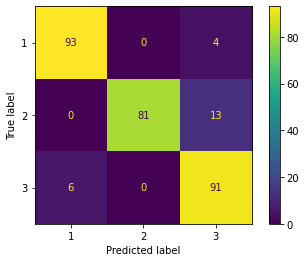

In [12]:
####################################################
# TRAIN EEGNET MODEL
####################################################

# Get train/test split of data from one session
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, ohe_labels, 
                                                    test_size = 0.3,
                                                    shuffle= True,
                                                    stratify= ohe_labels,                                                    
                                                    random_state=98)


# Train on train/test split of data from one session
## Train for 100 epochs
keras_eegnet_model.fit(
    x= X_train,
    y= y_train,
    batch_size= 32, # Default: 32
    epochs= 200, # Default: 1, how many times to loop over data
    verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
    callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02drop")], # To be used for TF Board
    validation_split= 0.2,
    shuffle= True,
    sample_weight= None, # Can be interesting due to time series
    )

# Get predictions
y_pred = keras_eegnet_model.predict(X_test)

# Convert labels back to original
y_test = ohe.inverse_transform(y_test)
y_pred = ohe.inverse_transform(y_pred)

# Calculate accuracy
accuracy =  accuracy_score(y_test, y_pred)

# Show results on rain/test split
print(f"Trained EEGNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del X_train
del X_test
del y_train
del y_test
del accuracy
del y_pred

In [13]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_eegnet_model
del mne_fixed_window_epochs_data
del ohe
del ohe_labels